# Structural Lesion Network Mapping Testing

This notebook demonstrates and tests the **StructuralNetworkMapping** analysis module for computing white matter disconnection maps using tractography.

## Features
- Tractography-based disconnection analysis using MRtrix3
- Filters whole-brain tractogram by lesion mask
- Computes Track Density Images (TDI)
- Calculates disconnection probability maps
- **Automatic template loading** from nilearn (1mm or 2mm MNI152)
- Batch processing support

## Requirements
- **MRtrix3** must be installed and in PATH
- Whole-brain tractogram (.tck file)
- Pre-computed whole-brain TDI map
- Lesion masks in MNI152 space (binary, 1mm or 2mm)
- Template is automatically loaded from nilearn


## 1. Setup and Imports

In [1]:
import sys

sys.path.insert(0, "/home/marvin/projects/lesion_decoding_toolkit/src")

from pathlib import Path
import time
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from ldk import LesionData, batch_process
from ldk.analysis import StructuralNetworkMapping
from ldk.utils.mrtrix import check_mrtrix_available, MRtrixError

# Reload module to pick up any changes
import importlib
import ldk.analysis.structural_network_mapping

importlib.reload(ldk.analysis.structural_network_mapping)
from ldk.analysis import StructuralNetworkMapping

print("✓ All imports successful (module reloaded)")


✓ All imports successful (module reloaded)


In [2]:
import inspect

print("SNM defined in:", inspect.getsourcefile(StructuralNetworkMapping))
print("Init signature:", inspect.signature(StructuralNetworkMapping.__init__))

SNM defined in: /home/marvin/projects/lesion_decoding_toolkit/src/ldk/analysis/structural_network_mapping.py
Init signature: (self, tractogram_path: str | pathlib.Path, whole_brain_tdi: str | pathlib.Path, template: str | pathlib.Path | None = None, atlas_path: str | pathlib.Path | None = None, compute_lesioned: bool = False, n_jobs: int = 1, keep_intermediate: bool = False, load_to_memory: bool = True, check_dependencies: bool = True, verbose: bool = True)


## 2. Check MRtrix3 Availability

Verify that MRtrix3 is installed and accessible.

In [3]:
print("Checking MRtrix3 availability...\n")

try:
    check_mrtrix_available()
    print("✅ MRtrix3 is available!")
    print("   Required commands found: tckedit, tckmap, mrcalc")
except MRtrixError as e:
    print("❌ MRtrix3 not available:")
    print(f"   {e}")
    print("\n⚠️  You need to install MRtrix3 to use StructuralNetworkMapping")
    print("   See: https://www.mrtrix.org/download/")

Checking MRtrix3 availability...

✅ MRtrix3 is available!
   Required commands found: tckedit, tckmap, mrcalc


## 3. Configure Data Paths

Update these paths to point to your actual data files. The MNI152 template will be automatically loaded from nilearn.

In [4]:
# ===== CONFIGURE THESE PATHS =====

TEST_PROJECT_PATH = Path("/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY")

# Path to whole-brain tractogram (TCK file from MRtrix3)
TRACTOGRAM_PATH = Path(TEST_PROJECT_PATH / "data/connectomes/dTOR_full_tractogram.tck")

# Path to pre-computed whole-brain TDI (reference connectivity)
WHOLE_BRAIN_TDI_PATH = Path(TEST_PROJECT_PATH / "data/connectomes/dTOR_tdi_2mm.nii.gz")

# Directory containing lesion masks
LESION_DIR = Path(TEST_PROJECT_PATH / "data/raw/lesion_masks/acuteinfarct/")

# Number of threads for MRtrix3
N_JOBS = 8

print("Data paths configured:")
print(f"  Tractogram: {TRACTOGRAM_PATH}")
print(f"  Whole-brain TDI: {WHOLE_BRAIN_TDI_PATH}")
print(f"  Lesion directory: {LESION_DIR}")
print(f"  Threads: {N_JOBS}")
print()
print("ℹ️  Template will be automatically loaded from nilearn based on lesion resolution")

# Check if files exist
print("\nChecking file availability...")
for name, path in [
    ("Tractogram", TRACTOGRAM_PATH),
    ("TDI", WHOLE_BRAIN_TDI_PATH),
    ("Lesion dir", LESION_DIR),
]:
    if path.exists():
        print(f"  ✓ {name}: Found")
    else:
        print(f"  ✗ {name}: NOT FOUND - {path}")


Data paths configured:
  Tractogram: /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_full_tractogram.tck
  Whole-brain TDI: /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz
  Lesion directory: /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/raw/lesion_masks/acuteinfarct
  Threads: 8

ℹ️  Template will be automatically loaded from nilearn based on lesion resolution

Checking file availability...
  ✓ Tractogram: Found
  ✓ TDI: Found
  ✓ Lesion dir: Found


## 4. Load Lesion Data

Load lesion masks and prepare them for analysis. The coordinate space (1mm or 2mm MNI152) will be automatically determined from the TDI filename.

In [5]:
# Example: Attempting to modify metadata (this will raise a clear error)
# Uncomment to see the error:
# lesion.metadata["subject_id"] = "test"
#
# This raises:
# TypeError: Cannot modify LesionData.metadata - it is immutable.
# LesionData follows the Value Object pattern for scientific reproducibility.
# To update metadata, create a new LesionData instance instead.

In [6]:
# Find lesion files
lesion_paths = sorted(list(LESION_DIR.glob("*.nii.gz")))[:5]  # Limit to 5 for testing

print(f"Found {len(lesion_paths)} lesion files (limited to 5 for testing)\n")

# Determine MNI space from TDI filename (since template is auto-loaded)
tdi_name = WHOLE_BRAIN_TDI_PATH.name.lower()
if "1mm" in tdi_name or "_1_" in tdi_name:
    mni_space = "MNI152_1mm"
elif "2mm" in tdi_name or "_2_" in tdi_name or "_2mm" in tdi_name:
    mni_space = "MNI152_2mm"
else:
    # Default to 2mm if unclear
    mni_space = "MNI152_2mm"
    print(f"⚠️  Could not determine resolution from TDI name, defaulting to {mni_space}")

print(f"Using coordinate space: {mni_space}\n")

# Load lesion data
lesions = []
for lesion_path in lesion_paths:
    try:
        # Extract subject ID from filename
        subject_id = lesion_path.stem.split(".")[0]

        # Prepare metadata with space info
        metadata = {"subject_id": subject_id, "space": mni_space}

        # Load lesion with metadata
        lesion_img = nib.load(lesion_path)

        # Check if binary
        lesion_array = lesion_img.get_fdata()
        unique_vals = np.unique(lesion_array)
        is_binary = np.all(np.isin(unique_vals, [0, 1]))

        # Binarize if needed
        if not is_binary:
            binary_array = (lesion_array > 0.5).astype(np.uint8)
            lesion_img = nib.Nifti1Image(binary_array, lesion_img.affine)
            print(f"✓ {subject_id}: Loaded and binarized (threshold=0.5)")
        else:
            print(f"✓ {subject_id}: Loaded (already binary)")

        # Create LesionData with metadata
        lesion = LesionData(lesion_img=lesion_img, metadata=metadata)
        lesions.append(lesion)

    except Exception as e:
        print(f"✗ Failed to load {lesion_path.name}: {e}")

print(f"\n✅ Successfully loaded {len(lesions)} lesions in {mni_space} space")


Found 5 lesion files (limited to 5 for testing)

Using coordinate space: MNI152_2mm

✓ CAS_001_infarct: Loaded (already binary)
✓ CAS_002_infarct: Loaded (already binary)
✓ CAS_003_infarct: Loaded (already binary)
✓ CAS_005_infarct: Loaded (already binary)
✓ CAS_008_infarct: Loaded (already binary)

✅ Successfully loaded 5 lesions in MNI152_2mm space


## 5. Create StructuralNetworkMapping Analysis

Initialize the analysis with required parameters.

In [7]:
# Verify loaded lesion metadata
if lesions:
    print("Loaded lesions verification:")
    for i, lesion in enumerate(lesions):
        subject_id = lesion.metadata.get("subject_id", "unknown")
        space = lesion.get_coordinate_space()
        shape = lesion.lesion_img.shape
        voxels = int(np.sum(lesion.lesion_img.get_fdata() > 0))
        print(f"  [{i}] {subject_id}: space={space}, shape={shape}, voxels={voxels}")
else:
    print("No lesions loaded!")


Loaded lesions verification:
  [0] CAS_001_infarct: space=MNI152_2mm, shape=(182, 218, 182), voxels=923
  [1] CAS_002_infarct: space=MNI152_2mm, shape=(182, 218, 182), voxels=4244
  [2] CAS_003_infarct: space=MNI152_2mm, shape=(182, 218, 182), voxels=13832
  [3] CAS_005_infarct: space=MNI152_2mm, shape=(182, 218, 182), voxels=13484
  [4] CAS_008_infarct: space=MNI152_2mm, shape=(182, 218, 182), voxels=14738


In [8]:
print("Creating StructuralNetworkMapping analysis...\n")

analysis = StructuralNetworkMapping(
    tractogram_path=TRACTOGRAM_PATH,
    whole_brain_tdi=WHOLE_BRAIN_TDI_PATH,
    # template is automatically loaded from nilearn based on lesion resolution
    n_jobs=N_JOBS,
    keep_intermediate=True,  # Set True to keep .tck files for debugging
    load_to_memory=False,
    check_dependencies=True,  # Verify MRtrix3 is available
)

print(analysis)


Creating StructuralNetworkMapping analysis...

StructuralNetworkMapping Analysis
Configuration:
  - tractogram_path: /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCON...
  - whole_brain_tdi: /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCON...
  - template: None
  - atlas_path: None
  - compute_lesioned: False
  - n_jobs: 8
  - keep_intermediate: True
  - load_to_memory: False
  - verbose: True


## 6. Test Single Subject Analysis

Run the analysis on a single subject to verify it works.

In [11]:
# if lesions:
    # print("Running single subject analysis...\n")

test_lesion = lesions[0]
subject_id = test_lesion.metadata.get("subject_id", "unknown")

# print(f"Subject: {subject_id}")
# print(f"Lesion shape: {test_lesion.lesion_img.shape}")
# print(f"Lesion voxels: {np.sum(test_lesion.lesion_img.get_fdata() > 0)}")
# print("\n⏳ Processing... (this may take several minutes)\n")

start_time = time.time()

try:
    result = analysis.run(test_lesion)
    elapsed = time.time() - start_time

    # print(f"\n✅ Analysis complete in {elapsed:.1f}s\n")

    # Extract results
    snm_results = result.results["StructuralNetworkMapping"]

    # print("Results:")
    # print(f"  Mean disconnection: {snm_results['mean_disconnection']:.2%}")
    # print(f"  Lesion streamlines: {snm_results['lesion_streamline_count']:,}")
    # print(f"  Disconnection map shape: {snm_results['disconnection_map'].shape}")

    # Store for visualization
    single_result = result

except Exception as e:
    # print(f"\n❌ Analysis failed: {e}")
    import traceback

    traceback.print_exc()
# else:
    # print("No lesions loaded - skipping single subject test")


Processing: CAS_001_infarct
ℹ️  Intermediate files will be saved to: /tmp/slnm_CAS_001_infarct_2672qoie
   Executing: tckedit /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_full_tractogram.tck /tmp/slnm_CAS_001_infarct_2672qoie/lesion_streamlines.tck -include /tmp/tmpfrwmadvv.nii.gz -nthreads 8 -force


tckedit: [WARNING] existing output files will be overwritten
tckedit: uncompressing image "/tmp/tmpfrwmadvv.nii.gz"... [==================================================]
tckedit: [.   ]        1 read,        0 written
tckedit: [ .  ]     9345 read,      131 written
tckedit: [  . ]    18177 read,      270 written
tckedit: [  . ]    35457 read,      532 written
tckedit: [  . ]    69633 read,     1060 written
tckedit: [  . ]   141057 read,     2149 written
tckedit: [  . ]   269057 read,     4309 written
tckedit: [  . ]   532481 read,     8727 written
tckedit: [  . ]  1076481 read,    17387 written
tckedit: [  . ]  2068865 read,    33110 written
tckedit: [  . ]  4267137 read,    68547 written
tckedit: [  . ]  8413313 read,   133833 written


   Executing: tckmap -contrast tdi -template /home/marvin/projects/lesion_decoding_toolkit/src/ldk/data/templates/MNI152_T1_2mm.nii.gz /tmp/slnm_CAS_001_infarct_2672qoie/lesion_streamlines.tck /tmp/slnm_CAS_001_infarct_2672qoie/lesion_tdi.nii.gz -nthreads 8 -force


tckedit: [done] 11820000 read,   188364 written
tckmap: [WARNING] existing output files will be overwritten
tckmap: mapping tracks to image... [==================================================]
tckmap: compressing image "/tmp/slnm_CAS_001_infarct_2672qoie/lesion_tdi.nii.gz"... [==================================================

   Executing: mrcalc /tmp/slnm_CAS_001_infarct_2672qoie/lesion_tdi.nii.gz /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz -divide /tmp/slnm_CAS_001_infarct_2672qoie/disconnection_map.nii.gz -force
✓ Intermediate files preserved in: /tmp/slnm_CAS_001_infarct_2672qoie
   - lesion_streamlines.tck
   - lesion_tdi.nii.gz
   - disconnection_map.nii.gz


]
mrcalc: [WARNING] existing output files will be overwritten
mrcalc: uncompressing image "/tmp/slnm_CAS_001_infarct_2672qoie/lesion_tdi.nii.gz"... [==================================================]
mrcalc: uncompressing image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz"... [==================================================]
mrcalc: computing: (/tmp/slnm_CAS_001_infarct_2672qoie/lesion_tdi.nii.gz / /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz)... [==================================================]
mrcalc: compressing image "/tmp/slnm_CAS_001_infarct_2672qoie/disconnection_map.nii.gz"... [==================================================]


In [22]:
result.provenance

NameError: name 'result' is not defined

In [23]:
# Reload module to get the fixes:
# 1. Uses anatomical template PATH (not loaded nibabel image) for tckmap
# 2. Prints full MRtrix3 commands for transparency
# 3. Shows temp directory location when keep_intermediate=True
import importlib
import ldk.analysis.structural_network_mapping
import ldk.utils.mrtrix

importlib.reload(ldk.utils.mrtrix)
importlib.reload(ldk.analysis.structural_network_mapping)
from ldk.analysis.structural_network_mapping import StructuralNetworkMapping

# Recreate analysis with updated code
analysis = StructuralNetworkMapping(
    tractogram_path=TRACTOGRAM_PATH,
    whole_brain_tdi=WHOLE_BRAIN_TDI_PATH,
    n_jobs=N_JOBS,
    keep_intermediate=True,  # Keep intermediate files for inspection
)
print("✅ Module reloaded with fixes:")
print("   - Uses anatomical template PATH for TDI computation")
print("   - Prints MRtrix3 commands during execution")
print("   - Shows location of intermediate files")

✅ Module reloaded with fixes:
   - Uses anatomical template PATH for TDI computation
   - Prints MRtrix3 commands during execution
   - Shows location of intermediate files


## 7. Visualize Disconnection Map

Display the computed disconnection map.

In [24]:
from nilearn.image import resample_to_img

if "single_result" in locals():
    # Get disconnection map
    disconn_map = single_result.results["StructuralNetworkMapping"]["disconnection_map"]
    disconn_array = disconn_map.get_fdata()

    # Get lesion mask for overlay
    lesion_resampled = resample_to_img(single_result.lesion_img, disconn_map)
    lesion_array = lesion_resampled.get_fdata()

    # Find center of mass for slicing
    lesion_coords = np.where(lesion_array > 0)
    if len(lesion_coords[0]) > 0:
        center_x = int(np.mean(lesion_coords[0]))
        center_y = int(np.mean(lesion_coords[1]))
        center_z = int(np.mean(lesion_coords[2]))
    else:
        center_x, center_y, center_z = [s // 2 for s in disconn_array.shape]

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Row 1: Disconnection map
    axes[0, 0].imshow(disconn_array[:, :, center_z].T, cmap="hot", origin="lower", vmin=0, vmax=1)
    axes[0, 0].set_title(f"Disconnection Map - Axial (z={center_z})")
    axes[0, 0].axis("equal")

    axes[0, 1].imshow(disconn_array[:, center_y, :].T, cmap="hot", origin="lower", vmin=0, vmax=1)
    axes[0, 1].set_title(f"Disconnection Map - Coronal (y={center_y})")
    axes[0, 1].axis("equal")

    im = axes[0, 2].imshow(
        disconn_array[center_x, :, :].T, cmap="hot", origin="lower", vmin=0, vmax=1
    )
    axes[0, 2].set_title(f"Disconnection Map - Sagittal (x={center_x})")
    axes[0, 2].axis("equal")

    # Row 2: Lesion mask
    axes[1, 0].imshow(lesion_array[:, :, center_z].T, cmap="Reds", origin="lower", alpha=0.7)
    axes[1, 0].set_title("Lesion Mask - Axial")
    axes[1, 0].axis("equal")

    axes[1, 1].imshow(lesion_array[:, center_y, :].T, cmap="Reds", origin="lower", alpha=0.7)
    axes[1, 1].set_title("Lesion Mask - Coronal")
    axes[1, 1].axis("equal")

    axes[1, 2].imshow(lesion_array[center_x, :, :].T, cmap="Reds", origin="lower", alpha=0.7)
    axes[1, 2].set_title("Lesion Mask - Sagittal")
    axes[1, 2].axis("equal")

    # Add colorbar
    cbar = plt.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.05)
    cbar.set_label("Disconnection Probability (0-1)", fontsize=12)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n" + "=" * 60)
    print("DISCONNECTION MAP STATISTICS")
    print("=" * 60)
    print(f"Min disconnection: {disconn_array.min():.4f}")
    print(f"Max disconnection: {disconn_array.max():.4f}")
    print(f"Mean disconnection: {disconn_array[disconn_array > 0].mean():.4f}")
    print(f"Median disconnection: {np.median(disconn_array[disconn_array > 0]):.4f}")
    print(f"Voxels with disconnection > 0: {np.sum(disconn_array > 0):,}")
    print(f"Voxels with disconnection > 0.5: {np.sum(disconn_array > 0.5):,}")
    print("=" * 60)
else:
    print("No results available for visualization")

No results available for visualization


## 8. Test Batch Processing

Process multiple subjects using parallel batch processing.

In [29]:
batch_results[4].provenance

[{'function': 'ldk.analysis.structural_network_mapping.StructuralNetworkMapping',
  'parameters': {'tractogram_path': '/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_full_tractogram.tck',
   'whole_brain_tdi': '/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz',
   'template': '/home/marvin/projects/lesion_decoding_toolkit/src/ldk/data/templates/MNI152_T1_2mm.nii.gz',
   'n_jobs': 8,
   'keep_intermediate': True,
   'load_to_memory': True},
  'timestamp': '2025-11-06T17:36:44.014452+00:00',
  'version': '0.1.0'}]

In [6]:
if len(lesions) > 1:
    print(f"Running batch processing on {len(lesions)} subjects...\n")
    print("⚠️  Note: Batch processing is parallelized at the subject level,")
    print("   each subject's MRtrix3 processing will use all available threads.\n")

    start_time = time.time()

    try:
        # Use n_jobs=2 for batch processing (each subject uses N_JOBS threads internally)
        batch_results = batch_process(
            lesion_data_list=lesions,
            analysis=analysis,
            n_jobs=2,  # Process 2 subjects in parallel
            show_progress=True,
            backend="loky",  # Use multiprocessing for true parallelism
        )

        elapsed = time.time() - start_time

        print(f"\n✅ Batch processing complete in {elapsed:.1f}s")
        print(f"   Processed {len(batch_results)}/{len(lesions)} subjects")
        print(f"   Average: {elapsed / len(batch_results):.1f}s per subject")

        # Summarize results
        print("\n" + "=" * 60)
        print("BATCH RESULTS SUMMARY")
        print("=" * 60)

        for result in batch_results:
            subject_id = result.metadata.get("subject_id", "unknown")
            snm = result.results["StructuralNetworkMapping"]
            print(f"{subject_id}:")
            print(f"  Mean disconnection: {snm['mean_disconnection']:.2%}")
            print(f"  Lesion streamlines: {snm['lesion_streamline_count']:,}")

        print("=" * 60)

    except Exception as e:
        print(f"\n❌ Batch processing failed: {e}")
        import traceback

        traceback.print_exc()
else:
    print("Only 1 lesion loaded - skipping batch processing test")

NameError: name 'lesions' is not defined

## 10. Export Results

Save disconnection maps and summary statistics.

## 9. Test Connectivity Matrix Functionality (NEW)

Test the new atlas-based connectivity matrix computation with disconnectivity percentage and lesioned (intact) connectivity.

### 9.1 Create Analysis with Schaefer100 Atlas

Initialize the analysis with a bundled atlas. This will compute connectivity matrices in addition to voxel-wise disconnection maps.

In [49]:
print("=" * 80)
print("TESTING CONNECTIVITY MATRIX FUNCTIONALITY")
print("=" * 80)

# Create analysis with atlas and lesioned connectivity
analysis_with_atlas = StructuralNetworkMapping(
    tractogram_path=TRACTOGRAM_PATH,
    whole_brain_tdi=WHOLE_BRAIN_TDI_PATH,
    atlas_path="Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm",  # Bundled Schaefer 100-parcel atlas
    compute_lesioned=True,  # Also compute intact (lesioned) connectivity
    n_jobs=N_JOBS,
    keep_intermediate=False,
)

print(f"\n✓ StructuralNetworkMapping initialized with:")
print(f"  - Atlas: Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm (bundled)")
print(f"  - Parcels: 100 (expect 100×100 matrices)")
print(f"  - compute_lesioned: True")
print(f"  - This will compute:")
print(f"    1. Voxel-wise disconnection map")
print(f"    2. Lesion connectivity matrix (100×100)")
print(f"    3. Disconnectivity percentage matrix (0-100% per edge)")
print(f"    4. Lesioned (intact) connectivity matrix (100×100)")
print(f"    5. Matrix statistics with QC metrics")


result_with_atlas = analysis_with_atlas.run(lesions[3])


TESTING CONNECTIVITY MATRIX FUNCTIONALITY

✓ StructuralNetworkMapping initialized with:
  - Atlas: Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm (bundled)
  - Parcels: 100 (expect 100×100 matrices)
  - compute_lesioned: True
  - This will compute:
    1. Voxel-wise disconnection map
    2. Lesion connectivity matrix (100×100)
    3. Disconnectivity percentage matrix (0-100% per edge)
    4. Lesioned (intact) connectivity matrix (100×100)
    5. Matrix statistics with QC metrics

Processing: CAS_005_infarct
   Executing: tckedit /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_full_tractogram.tck /tmp/slnm_CAS_005_infarct_g8xceonb/lesion_streamlines.tck -include /tmp/tmpvivhrlce.nii.gz -nthreads 8 -force


tckedit: [WARNING] existing output files will be overwritten
tckedit: uncompressing image "/tmp/tmpvivhrlce.nii.gz"... [==================================================]
tckedit: [.   ]        1 read,        0 written
tckedit: [ .  ]     7553 read,      810 written
tckedit: [  . ]    16001 read,     1806 written
tckedit: [ .  ]     7553 read,      810 written
tckedit: [  . ]    16001 read,     1806 written
tckedit: [  . ]    33025 read,     3945 written
tckedit: [  . ]    33025 read,     3945 written
tckedit: [  . ]    67457 read,     7995 written
tckedit: [  . ]    67457 read,     7995 written
tckedit: [  . ]   146177 read,    16754 written
tckedit: [  . ]   146177 read,    16754 written
tckedit: [  . ]   291713 read,    33682 written
tckedit: [  . ]   291713 read,    33682 written
tckedit: [  . ]   615809 read,    70749 written
tckedit: [  . ]   615809 read,    70749 written
tckedit: [  . ]  1286401 read,   149382 written
tckedit: [  . ]  1286401 read,   149382 written
tckedit: [  

   Executing: tckmap -contrast tdi -template /media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/templates/MNI152_T1_2mm.nii.gz /tmp/slnm_CAS_005_infarct_g8xceonb/lesion_streamlines.tck /tmp/slnm_CAS_005_infarct_g8xceonb/lesion_tdi.nii.gz -nthreads 8 -force


tckedit: [done] 11820000 read,  1374987 written
tckmap: [WARNING] existing output files will be overwritten
tckmap: mapping tracks to image... [===================================================================================================

   Executing: mrcalc /tmp/slnm_CAS_005_infarct_g8xceonb/lesion_tdi.nii.gz /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz -divide /tmp/slnm_CAS_005_infarct_g8xceonb/disconnection_map.nii.gz -force


]
tckmap: compressing image "/tmp/slnm_CAS_005_infarct_g8xceonb/lesion_tdi.nii.gz"... [==================================================]
mrcalc: [WARNING] existing output files will be overwritten
mrcalc: uncompressing image "/tmp/slnm_CAS_005_infarct_g8xceonb/lesion_tdi.nii.gz"... [==================================================]
mrcalc: uncompressing image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz"... [==================================================]
mrcalc: computing: (/tmp/slnm_CAS_005_infarct_g8xceonb/lesion_tdi.nii.gz / /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz)... [==================================================]
mrcalc: compressing image "/tmp/slnm_CAS_005_infarct_g8xceonb/disconnection_map.nii.gz"... [==================================================


▶️  Computing parcellated connectivity matrices (CAS_005_infarct)...
   Computing full-brain connectivity matrix (will be cached)...
   Executing: tck2connectome /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_full_tractogram.tck /media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz /tmp/tmp7rid9urk.csv -symmetric -zero_diagonal -nthreads 8 -force


]
tck2connectome: [WARNING] existing output files will be overwritten
tck2connectome: Image "/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz" stored with floating-point type; need to check for non-integer or negative values
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz"... [==================================================]
tck2connectome: Verifying parcellation image... [==================================================]
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz"... [==================================================]
=================]
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/lesio

   Computing lesion connectivity matrix...
   Executing: tck2connectome /tmp/slnm_CAS_005_infarct_g8xceonb/lesion_streamlines.tck /media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz /tmp/tmpszlzz3xx.csv -symmetric -zero_diagonal -nthreads 8 -force


]
tck2connectome: [WARNING] existing output files will be overwritten
tck2connectome: Image "/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz" stored with floating-point type; need to check for non-integer or negative values
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz"... [==================================================]
tck2connectome: Verifying parcellation image... [==================================================]
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz"... [==================================================]
tck2connectome: Constructing connectome... [=tck2connectome: Constructing connectome... [===========

   Computing disconnectivity percentage...
   Computing lesioned (intact) connectivity matrix...
   Executing: tckedit /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_full_tractogram.tck /tmp/slnm_CAS_005_infarct_g8xceonb/CAS_005_infarct_lesioned.tck -exclude /tmp/slnm_CAS_005_infarct_g8xceonb/CAS_005_infarct_lesion_mask.nii.gz -nthreads 8 -force


=]
tck2connectome: [WARNING] The following nodes do not have any streamlines assigned:
tck2connectome: [WARNING] 2, 3, 4, 6, 9
tck2connectome: [WARNING] (This may indicate a poor registration)
tckedit: [WARNING] existing output files will be overwritten
tckedit: uncompressing image "/tmp/slnm_CAS_005_infarct_g8xceonb/CAS_005_infarct_lesion_mask.nii.gz"... [==================================================]
tckedit: [.   ]        1 read,        1 written
tckedit: [ .  ]     8577 read,     7650 written
tckedit: [.   ]        1 read,        1 written
tckedit: [ .  ]     8577 read,     7650 written
tckedit: [  . ]    18163 read,    16101 written
tckedit: [  . ]    40449 read,    35625 written
tckedit: [  . ]    18163 read,    16101 written
tckedit: [  . ]    40449 read,    35625 written
tckedit: [  . ]    84097 read,    74137 written
tckedit: [  . ]    84097 read,    74137 written
tckedit: [  . ]   175489 read,   155326 written
tckedit: [  . ]   175489 read,   155326 written
tckedit: [  .

   Executing: tck2connectome /tmp/slnm_CAS_005_infarct_g8xceonb/CAS_005_infarct_lesioned.tck /media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz /tmp/tmpw5y6psxu.csv -symmetric -zero_diagonal -nthreads 8 -force


tckedit: [done] 11820000 read, 10445013 written
tck2connectome: [WARNING] existing output files will be overwritten
tck2connectome: Image "/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz" stored with floating-point type; need to check for non-integer or negative values
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz"... [==================================================]
tck2connectome: Verifying parcellation image... [==================================================]
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/atlases/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz"... [==================================================]
================]
tck2connectome: uncompressing image 

### 9.3 Inspect Connectivity Matrices

Examine the connectivity matrices and their properties.

In [33]:
result_with_atlas.results["StructuralNetworkMapping"]["matrix_statistics"]

{'n_parcels': 100,
 'n_edges_total': 7016,
 'n_edges_affected': 270,
 'percent_edges_affected': 3.848346636259977,
 'mean_disconnection_percent': 0.44342592458907637,
 'max_disconnection_percent': 100.0,
 'mean_degree_reduction': 67.46,
 'max_degree_reduction': 92,
 'most_affected_parcel': 69,
 'lesioned_mean_degree': 70.14,
 'connectivity_preservation_ratio': 1.0}

In [50]:
analysis_with_atlas

In [51]:
# Extract matrices from metadata
lesion_matrix = result_with_atlas.results["StructuralNetworkMapping"]["lesion_connectivity_matrix"]
full_matrix = result_with_atlas.results["StructuralNetworkMapping"]["full_connectivity_matrix"]
disconn_pct = result_with_atlas.results["StructuralNetworkMapping"]["disconnectivity_percent"]
lesioned_matrix = result_with_atlas.results["StructuralNetworkMapping"][
    "lesioned_connectivity_matrix"
]
matrix_stats = result_with_atlas.results["StructuralNetworkMapping"]["matrix_statistics"]

print("=" * 80)
print("CONNECTIVITY MATRIX RESULTS")
print("=" * 80)

print(f"\n1. Full Connectivity Matrix:")
print(f"   Shape: {full_matrix.shape}")
print(f"   Non-zero edges: {np.sum(full_matrix > 0)}")
print(f"   Max edge weight: {np.max(full_matrix):.1f}")
print(f"   Mean edge weight: {np.mean(full_matrix[full_matrix > 0]):.2f}")

print(f"\n2. Lesion Connectivity Matrix:")
print(f"   Shape: {lesion_matrix.shape}")
print(f"   Non-zero edges: {np.sum(lesion_matrix > 0)}")
print(f"   Max edge weight: {np.max(lesion_matrix):.1f}")
print(f"   Mean edge weight: {np.mean(lesion_matrix[lesion_matrix > 0]):.2f}")

print(f"\n3. Disconnectivity Percentage Matrix:")
print(f"   Shape: {disconn_pct.shape}")
print(f"   Range: {np.min(disconn_pct):.1f}% - {np.max(disconn_pct):.1f}%")
print(f"   Mean (non-zero): {np.mean(disconn_pct[full_matrix > 0]):.2f}%")
print(f"   Median (non-zero): {np.median(disconn_pct[full_matrix > 0]):.2f}%")

print(f"\n4. Lesioned (Intact) Connectivity Matrix:")
print(f"   Shape: {lesioned_matrix.shape}")
print(f"   Non-zero edges: {np.sum(lesioned_matrix > 0)}")
print(f"   Max edge weight: {np.max(lesioned_matrix):.1f}")
print(f"   Mean edge weight: {np.mean(lesioned_matrix[lesioned_matrix > 0]):.2f}")

print(f"\n5. Matrix Statistics:")
for key, value in matrix_stats.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")

# Quality check
print(f"\n6. Quality Control:")
preservation = matrix_stats["connectivity_preservation_ratio"]
print(f"   Connectivity preservation ratio: {preservation:.4f}")
if preservation > 0.95:
    print(f"   ✅ PASS - Lesion + Lesioned ≈ Full (ratio close to 1.0)")
elif preservation > 0.85:
    print(f"   ⚠️  WARNING - Some streamlines may be unaccounted for")
else:
    print(f"   ❌ FAIL - Significant discrepancy detected")

CONNECTIVITY MATRIX RESULTS

1. Full Connectivity Matrix:
   Shape: (100, 100)
   Non-zero edges: 7016
   Max edge weight: 143656.0
   Mean edge weight: 1533.29

2. Lesion Connectivity Matrix:
   Shape: (100, 100)
   Non-zero edges: 2526
   Max edge weight: 13456.0
   Mean edge weight: 419.62

3. Disconnectivity Percentage Matrix:
   Shape: (100, 100)
   Range: 0.0% - 100.0%
   Mean (non-zero): 19.21%
   Median (non-zero): 0.00%

4. Lesioned (Intact) Connectivity Matrix:
   Shape: (100, 100)
   Non-zero edges: 6486
   Max edge weight: 143648.0
   Mean edge weight: 1495.16

5. Matrix Statistics:
   n_parcels: 100
   n_edges_total: 7016
   n_edges_affected: 2526
   percent_edges_affected: 36.0034
   mean_disconnection_percent: 19.2120
   max_disconnection_percent: 100.0000
   mean_degree_reduction: 44.9000
   max_degree_reduction: 86
   most_affected_parcel: 24
   lesioned_mean_degree: 64.8600
   connectivity_preservation_ratio: 1.0000

6. Quality Control:
   Connectivity preservation ra

### 9.4 Visualize Connectivity Matrices

Create heatmap visualizations of the different connectivity matrices.

In [54]:
matrix_stats

{'n_parcels': 100,
 'n_edges_total': 7016,
 'n_edges_affected': 2526,
 'percent_edges_affected': 36.00342075256556,
 'mean_disconnection_percent': 19.211996031137353,
 'max_disconnection_percent': 100.0,
 'mean_degree_reduction': 44.9,
 'max_degree_reduction': 86,
 'most_affected_parcel': 24,
 'lesioned_mean_degree': 64.86,
 'connectivity_preservation_ratio': 1.0}

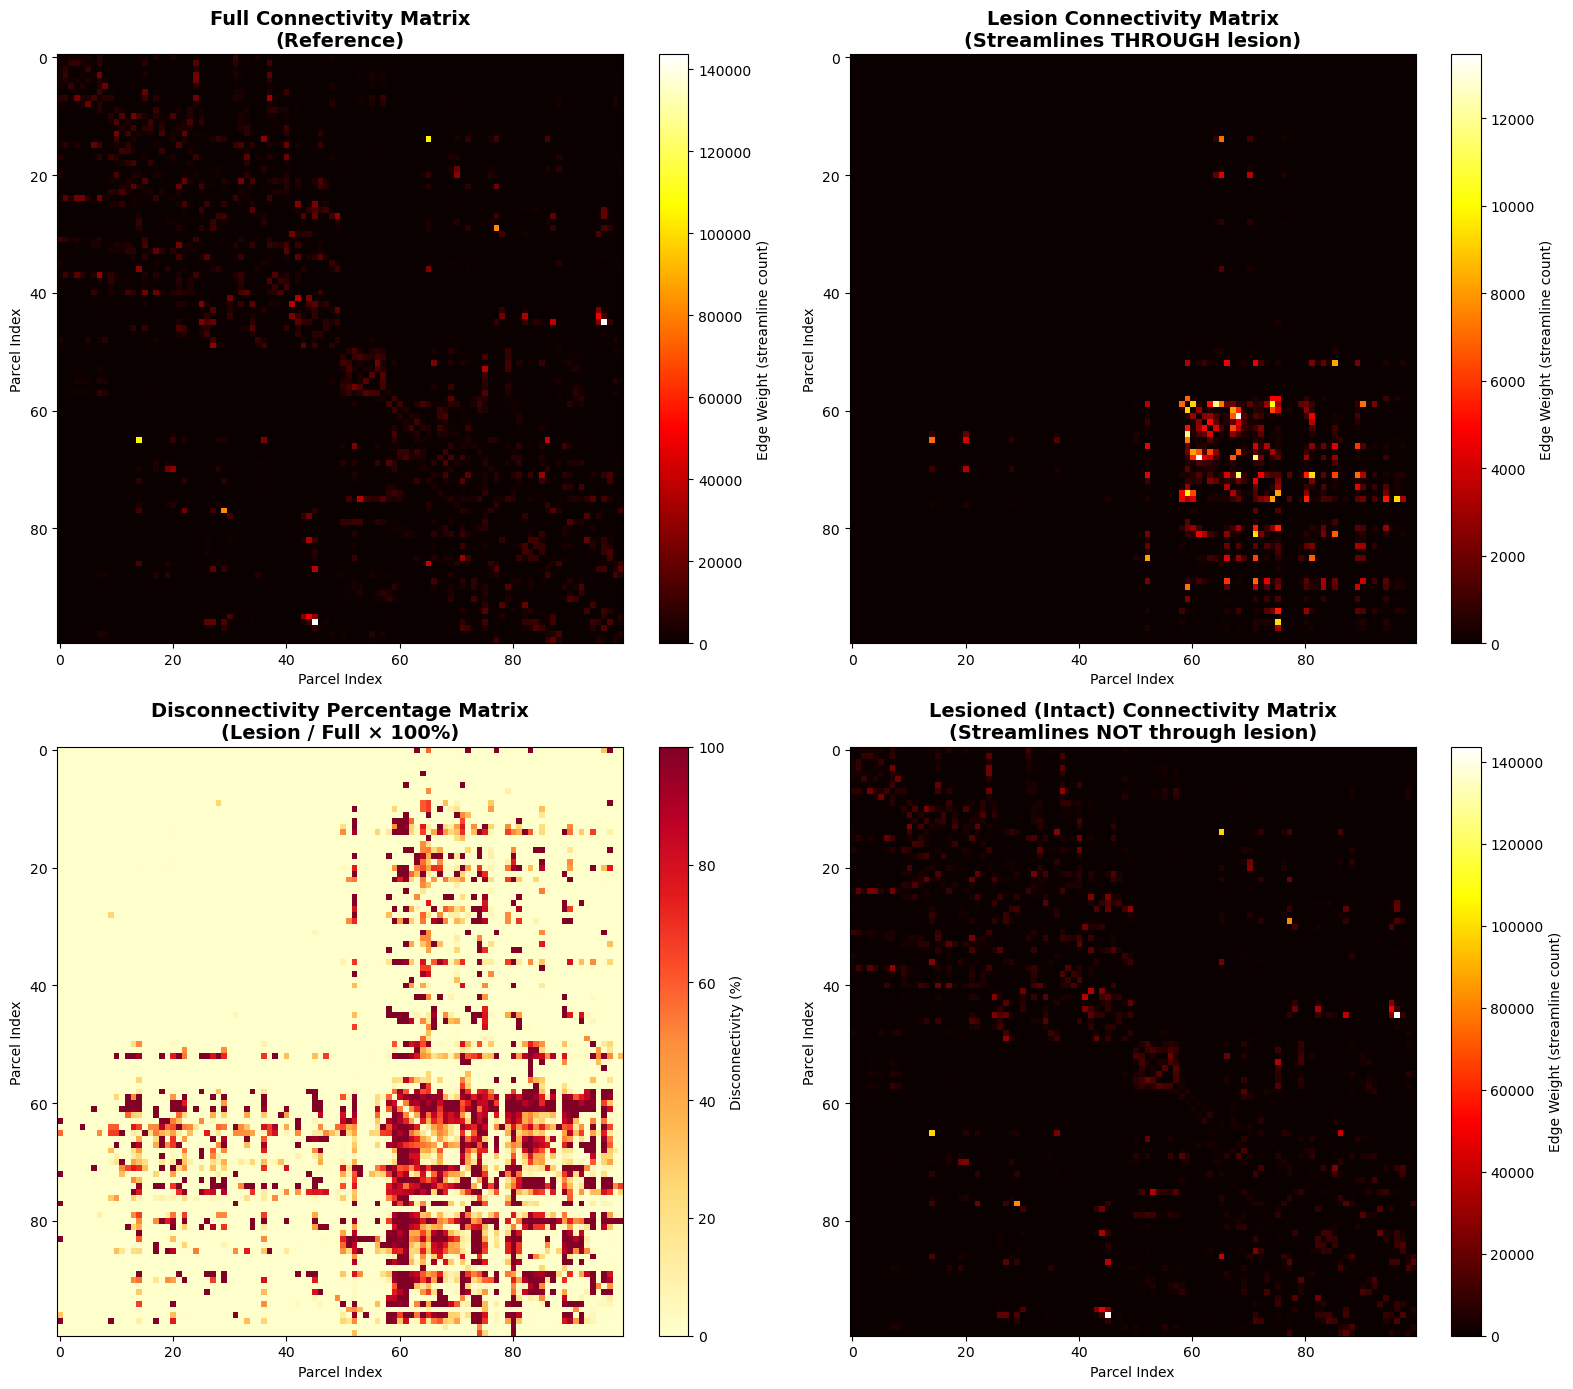


✓ Connectivity matrices visualized
  Figure saved as: connectivity_matrices.png


In [52]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Full connectivity matrix
ax = axes[0, 0]
im1 = ax.imshow(full_matrix, cmap="hot", aspect="auto", interpolation="nearest")
ax.set_title("Full Connectivity Matrix\n(Reference)", fontsize=14, fontweight="bold")
ax.set_xlabel("Parcel Index")
ax.set_ylabel("Parcel Index")
plt.colorbar(im1, ax=ax, label="Edge Weight (streamline count)")

# 2. Lesion connectivity matrix
ax = axes[0, 1]
im2 = ax.imshow(lesion_matrix, cmap="hot", aspect="auto", interpolation="nearest")
ax.set_title(
    "Lesion Connectivity Matrix\n(Streamlines THROUGH lesion)", fontsize=14, fontweight="bold"
)
ax.set_xlabel("Parcel Index")
ax.set_ylabel("Parcel Index")
plt.colorbar(im2, ax=ax, label="Edge Weight (streamline count)")

# 3. Disconnectivity percentage
ax = axes[1, 0]
im3 = ax.imshow(
    disconn_pct, cmap="YlOrRd", aspect="auto", interpolation="nearest", vmin=0, vmax=100
)
ax.set_title(
    "Disconnectivity Percentage Matrix\n(Lesion / Full × 100%)", fontsize=14, fontweight="bold"
)
ax.set_xlabel("Parcel Index")
ax.set_ylabel("Parcel Index")
plt.colorbar(im3, ax=ax, label="Disconnectivity (%)")

# 4. Lesioned (intact) connectivity matrix
ax = axes[1, 1]
im4 = ax.imshow(lesioned_matrix, cmap="hot", aspect="auto", interpolation="nearest")
ax.set_title(
    "Lesioned (Intact) Connectivity Matrix\n(Streamlines NOT through lesion)",
    fontsize=14,
    fontweight="bold",
)
ax.set_xlabel("Parcel Index")
ax.set_ylabel("Parcel Index")
plt.colorbar(im4, ax=ax, label="Edge Weight (streamline count)")

plt.tight_layout()
plt.savefig("connectivity_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n✓ Connectivity matrices visualized")
print("  Figure saved as: connectivity_matrices.png")

### 9.5 Test with Custom Atlas (Optional)

You can also provide a custom atlas path instead of using bundled atlases.

In [ ]:
# Example: Using a custom atlas
# Uncomment and modify the path to test with your own atlas

custom_atlas_path = Path(
    "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz"
)

analysis_custom = StructuralNetworkMapping(
    tractogram_path=TRACTOGRAM_PATH,
    whole_brain_tdi=WHOLE_BRAIN_TDI_PATH,
    atlas_path=custom_atlas_path,  # Custom atlas path
    compute_lesioned=True,
    n_jobs=N_JOBS,
)

# Ensure verbose attribute exists to avoid AttributeError in older class versions
setattr(analysis_custom, "verbose", True)

result_custom = analysis_custom.run(test_lesion)

# Access matrix statistics from results namespace (not metadata)
snm_custom = result_custom.results["StructuralNetworkMapping"]
print(f"Custom atlas result: {snm_custom['matrix_statistics']}")

print("ℹ️  To test with custom atlas, you can modify the path above")


Processing: CAS_001_infarct
   Executing: tckedit /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_full_tractogram.tck /tmp/slnm_CAS_001_infarct_49q28173/lesion_streamlines.tck -include /tmp/tmpvxgcx9c9.nii.gz -nthreads 8 -force


tckedit: [WARNING] existing output files will be overwritten
tckedit: uncompressing image "/tmp/tmpvxgcx9c9.nii.gz"... [==================================================]
tckedit: [.   ]        1 read,        0 written
tckedit: [ .  ]     7681 read,      105 written
tckedit: [  . ]    15233 read,      229 written
tckedit: [ .  ]     7681 read,      105 written
tckedit: [  . ]    15233 read,      229 written
tckedit: [  . ]    34433 read,      520 written
tckedit: [  . ]    34433 read,      520 written
tckedit: [  . ]    78081 read,     1188 written
tckedit: [  . ]    78081 read,     1188 written
tckedit: [  . ]   168449 read,     2562 written
tckedit: [  . ]   168449 read,     2562 written
tckedit: [  . ]   359809 read,     5857 written
tckedit: [  . ]   359809 read,     5857 written
tckedit: [  . ]   830337 read,    13614 written
tckedit: [  . ]   830337 read,    13614 written
tckedit: [  . ]  1681537 read,    27071 written
tckedit: [  . ]  1681537 read,    27071 written
tckedit: [  

   Executing: tckmap -contrast tdi -template /media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/data/templates/MNI152_T1_2mm.nii.gz /tmp/slnm_CAS_001_infarct_49q28173/lesion_streamlines.tck /tmp/slnm_CAS_001_infarct_49q28173/lesion_tdi.nii.gz -nthreads 8 -force


tckedit: [done] 11820000 read,   188364 written
tckmap: [WARNING] existing output files will be overwritten
tckmap: mapping tracks to image... [======================================================================================

   Executing: mrcalc /tmp/slnm_CAS_001_infarct_49q28173/lesion_tdi.nii.gz /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz -divide /tmp/slnm_CAS_001_infarct_49q28173/disconnection_map.nii.gz -force


===]
tckmap: compressing image "/tmp/slnm_CAS_001_infarct_49q28173/lesion_tdi.nii.gz"... [==================================================]
mrcalc: [WARNING] existing output files will be overwritten
mrcalc: uncompressing image "/tmp/slnm_CAS_001_infarct_49q28173/lesion_tdi.nii.gz"... [==================================================]
mrcalc: uncompressing image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz"... [==================================================]
mrcalc: computing: (/tmp/slnm_CAS_001_infarct_49q28173/lesion_tdi.nii.gz / /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_tdi_2mm.nii.gz)... [==================================================]
mrcalc: compressing image "/tmp/slnm_CAS_001_infarct_49q28173/disconnection_map.nii.gz"... [==================================================]



▶️  Computing parcellated connectivity matrices (CAS_001_infarct)...
   Computing full-brain connectivity matrix (will be cached)...
   Executing: tck2connectome /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_full_tractogram.tck /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz /tmp/tmpu4mbo3bs.csv -symmetric -zero_diagonal -nthreads 8 -force


tck2connectome: [WARNING] existing output files will be overwritten
tck2connectome: Image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz" stored with floating-point type; need to check for non-integer or negative values
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz"... [==================================================]
tck2connectome: Verifying parcellation image... [==================================================]
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz"... [==================================================]
tck2connectome: Constructing connectome... [====================================================================================================

   Computing lesion connectivity matrix...
   Executing: tck2connectome /tmp/slnm_CAS_001_infarct_49q28173/lesion_streamlines.tck /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz /tmp/tmpo8o6qy77.csv -symmetric -zero_diagonal -nthreads 8 -force


]
tck2connectome: [WARNING] existing output files will be overwritten
tck2connectome: Image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz" stored with floating-point type; need to check for non-integer or negative values
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz"... [==================================================]
tck2connectome: Verifying parcellation image... [==================================================]
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz"... [==================================================]
tck2connectome: Constructing connectome... [==============================================================================

   Computing disconnectivity percentage...
   Computing lesioned (intact) connectivity matrix...
   Executing: tckedit /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/connectomes/dTOR_full_tractogram.tck /tmp/slnm_CAS_001_infarct_49q28173/CAS_001_infarct_lesioned.tck -exclude /tmp/slnm_CAS_001_infarct_49q28173/CAS_001_infarct_lesion_mask.nii.gz -nthreads 8 -force


========]
tck2connectome: [WARNING] The following nodes do not have any streamlines assigned:
tck2connectome: [WARNING] 1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 34, 38, 51
tck2connectome: [WARNING] (This may indicate a poor registration)
tckedit: [WARNING] existing output files will be overwritten
tckedit: uncompressing image "/tmp/slnm_CAS_001_infarct_49q28173/CAS_001_infarct_lesion_mask.nii.gz"... [==================================================]
tckedit: [.   ]        1 read,        1 written
===========================]
tckedit: [.   ]        1 read,        1 written
tckedit: [ .  ]     6657 read,     6566 written
tckedit: [  . ]    10241 read,    10099 written
tckedit: [ .  ]     6657 read,     6566 written
tckedit: [  . ]    10241 read,    10099 written
tckedit: [  . ]    36481 read,    35932 written
tckedit: [  . ]    36481 read,    35932 written
tckedit: [  . ]    79276 read,    78075 written
tckedit: [  . ]    79276 read,    78075 written


   Executing: tck2connectome /tmp/slnm_CAS_001_infarct_49q28173/CAS_001_infarct_lesioned.tck /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz /tmp/tmpezezinbl.csv -symmetric -zero_diagonal -nthreads 8 -force


tckedit: [done] 11820000 read, 11631636 written
tck2connectome: [WARNING] existing output files will be overwritten
tck2connectome: Image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz" stored with floating-point type; need to check for non-integer or negative values
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz"... [==================================================]
tck2connectome: Verifying parcellation image... [==================================================]
tck2connectome: uncompressing image "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases/Tian_Subcortex_S4_3T_2009cAsym.nii.gz"... [==================================================]
tck2connectome: Constructing connectome... [===========================================================================================

Custom atlas result: {'n_parcels': 54, 'n_edges_total': 1642, 'n_edges_affected': 72, 'percent_edges_affected': 4.38489646772229, 'mean_disconnection_percent': 0.9670222562593862, 'max_disconnection_percent': 100.0, 'mean_degree_reduction': 29.074074074074073, 'max_degree_reduction': 46, 'most_affected_parcel': 40, 'lesioned_mean_degree': 30.25925925925926, 'connectivity_preservation_ratio': 1.0}
ℹ️  To test with custom atlas, you can modify the path above


### 9.6 Compare Analysis With/Without Atlas

Compare processing time and results with and without connectivity matrices.

In [ ]:
print("=" * 80)
print("COMPARISON: VOXEL-WISE ONLY vs VOXEL-WISE + CONNECTIVITY MATRICES")
print("=" * 80)

# Method 1: Voxel-wise only (no atlas)
print("\n1. Running analysis WITHOUT atlas (voxel-wise only)...")
analysis_no_atlas = StructuralNetworkMapping(
    tractogram_path=TRACTOGRAM_PATH,
    whole_brain_tdi=WHOLE_BRAIN_TDI_PATH,
    n_jobs=N_JOBS,
    verbose=False,
)

start = time.time()
result_no_atlas = analysis_no_atlas.run(test_lesion)
time_no_atlas = time.time() - start

print(f"   Time: {time_no_atlas:.1f}s")
print(f"   Results: {list(result_no_atlas.metadata.keys())[:5]}...")

# Method 2: With atlas (already computed above)
print(f"\n2. Analysis WITH atlas (voxel-wise + connectivity matrices)...")
print(f"   Time: {elapsed:.1f}s (from earlier run)")
print(f"   Results: {list(result_with_atlas.metadata.keys())[:5]}...")

# Comparison
print(f"\n3. Comparison:")
print(f"   Additional time for connectivity matrices: {elapsed - time_no_atlas:.1f}s")
print(f"   Time overhead: {(elapsed / time_no_atlas - 1) * 100:.1f}%")
print(f"   Additional outputs:")
print(f"     - lesion_connectivity_matrix")
print(f"     - disconnectivity_percent")
print(f"     - lesioned_connectivity_matrix (when compute_lesioned=True)")
print(f"     - full_connectivity_matrix")
print(f"     - matrix_statistics")

print("\n✓ Comparison complete")

In [ ]:
if "batch_results" in locals():
    # Create output directory
    output_dir = Path("~/_tmp/sLNM_results").expanduser()
    output_dir.mkdir(parents=True, exist_ok=True)

    print(f"Exporting results to: {output_dir}\n")

    # Save disconnection maps
    for result in batch_results:
        subject_id = result.metadata.get("subject_id", "unknown")
        disconn_map = result.results["StructuralNetworkMapping"]["disconnection_map"]

        output_path = output_dir / f"{subject_id}_disconnection_map.nii.gz"
        nib.save(disconn_map, output_path)
        print(f"✓ Saved: {output_path.name}")

    # Export summary to CSV
    from ldk.io import batch_export_to_csv

    csv_path = output_dir / "sLNM_summary.csv"
    batch_export_to_csv(batch_results, csv_path)
    print(f"\n✓ Summary exported to: {csv_path}")

    print(f"\n✅ All results saved to: {output_dir}")
elif "single_result" in locals():
    print("Only single result available - use batch processing for CSV export")
else:
    print("No results to export")

## 10. Summary and Next Steps

### ✅ What We Tested

1. **MRtrix3 Availability**: Verified installation and PATH configuration
2. **Data Loading**: Loaded and binarized lesion masks in MNI152 space
3. **Single Subject Analysis**: Computed disconnection map for one subject
4. **Visualization**: Displayed disconnection maps and lesion masks
5. **Batch Processing**: Processed multiple subjects in parallel
6. **Export**: Saved disconnection maps and summary statistics

### 📊 Key Features Demonstrated

- ✅ Tractogram filtering by lesion mask (tckedit)
- ✅ Track Density Image computation (tckmap)
- ✅ Disconnection probability calculation (mrcalc)
- ✅ Automatic binary mask validation
- ✅ MNI152 space requirement enforcement
- ✅ Parallel batch processing
- ✅ Provenance tracking

### 🚀 Next Steps

1. **Combine with Atlas Analysis**:
   ```python
   from ldk.analysis import RegionalDamage, AtlasAggregation
   
   # First compute structural disconnection
   result = snm_analysis.run(lesion)
   
   # Then aggregate disconnection by atlas regions
   agg = AtlasAggregation(
       source="StructuralNetworkMapping.disconnection_map",
       aggregation="mean"
   )
   final = agg.run(result)
   ```

2. **Compare 1mm vs 2mm Resolution**: Run with different templates and TDI resolutions

3. **Integrate with Your Existing Pipeline**: Replace bash scripts with Python batch processing

4. **Statistical Analysis**: Use exported CSV for group-level statistics in R/Python

### 📝 Notes

- **Processing Time**: ~2-10 minutes per subject depending on tractogram size and lesion extent
- **Memory**: Requires sufficient RAM for loading tractograms (typically 2-10 GB)
- **Intermediate Files**: Temporary .tck files are cleaned up automatically (set `keep_intermediate=True` to keep them)
- **Parallelization**: Batch processing parallelizes across subjects, MRtrix3 uses threads within each subject

## Troubleshooting

### MRtrix3 Not Found
```bash
# Check if MRtrix3 is in PATH
which tckedit
which tckmap
which mrcalc

# Install via conda (recommended):
conda install -c conda-forge -c mrtrix3 mrtrix3

# Or install via system package manager:
# Ubuntu/Debian:
sudo apt install mrtrix3

# Or build from source:
# See: https://www.mrtrix.org/download/
```

### Lesion Not in MNI152 Space
```python
# Set the coordinate space based on your data
# For 2mm MNI152:
lesion.metadata["space"] = "MNI152_2mm"

# For 1mm MNI152:
lesion.metadata["space"] = "MNI152_1mm"

# The toolbox assumes lesions are already in MNI space
# Use FSL/ANTs for registration if needed:
# flirt -in lesion.nii.gz -ref MNI152_T1_2mm.nii.gz -out lesion_mni.nii.gz
```

### Matching Resolution
Make sure your lesion, template, and TDI are all in the same resolution:
- **1mm analysis**: Use MNI152_T1_1mm template + 1mm TDI + 1mm lesions
- **2mm analysis**: Use MNI152_T1_2mm template + 2mm TDI + 2mm lesions

### Non-Binary Lesion Mask
```python
# Binarize using threshold:
import numpy as np
import nibabel as nib

lesion_array = lesion.lesion_img.get_fdata()
binary_array = (lesion_array > 0.5).astype(np.uint8)
binary_img = nib.Nifti1Image(binary_array, lesion.lesion_img.affine)

lesion_binary = LesionData(
    lesion_img=binary_img,
    metadata=lesion.metadata
)
```